In [12]:
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.utils.extmath import safe_sparse_dot

from scipy.sparse.linalg import svds
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import inv
from scipy.spatial import cKDTree

from numpy.core.umath_tests import inner1d
from numpy.linalg import matrix_rank
import matplotlib.pyplot as plt
import os.path as path
import seaborn as sns
import numexpr as ne
import pandas as pd
import scanpy as sc
import numpy as np
import anndata
import h5py
import time
#del umap
import gc

## read data

In [ ]:
scATAC = pd.read_csv('./PBMC-Multiome10k/scATACseq.csv')
scRNA = pd.read_csv('./PBMC-Multiome10k/scRNAseq.csv')

In [ ]:
scATAC.index=scATAC['Unnamed: 0']
scATAC = scATAC.drop(columns='Unnamed: 0')
scRNA.index=scRNA['Unnamed: 0']
scRNA = scRNA.drop(columns='Unnamed: 0')

## processing and filtering

In [ ]:
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(scATAC.T)  
#查看数据结构 tfidf[i][j]表示i类文本中的tf-idf权重  
X_atac = tfidf.toarray()

In [ ]:
Apeak = sc.AnnData(X_atac)
Agene = sc.AnnData(scRNA.T)

In [ ]:
sc.pp.filter_genes(Apeak, min_cells=50)
sc.pp.filter_genes(Agene, min_cells=50)

In [ ]:
sc.pp.highly_variable_genes(Agene, min_mean=0.0125, max_mean=3.5, min_disp=-1,n_bins=20)
sc.pl.highly_variable_genes(Agene)

In [ ]:
sc.pp.highly_variable_genes(Apeak, min_mean=0.0002, max_mean=3, min_disp=-5,n_bins=20)
sc.pl.highly_variable_genes(Apeak)

In [ ]:
HVG=Agene[:,Agene.var['highly_variable']==True]
HVP=Apeak[:,Apeak.var['highly_variable']==True]

In [ ]:
X_gene = np.array(HVG.X)
tfidf = transformer.fit_transform(X_gene)  
#查看数据结构 tfidf[i][j]表示i类文本中的tf-idf权重  
X_gene = tfidf.toarray()

In [ ]:
HVG.X=X_gene

## perform integration using TriTan

In [4]:
Agene = anndata.read_h5ad('./PBMC-Multiome10k/scRNA_filtered.h5ad')
Apeak = anndata.read_h5ad('./PBMC-Multiome10k/scATAC_filtered.h5ad')

In [96]:
mdata = MuData({"rna": Agene, "atac": Apeak})

In [5]:
import TriTan

/mnt/iusers01/fatpou01/bmh01/t48955xm/.conda/envs/maxxxxxxxin/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
mdata = md.read("./PBMC-Multiome10k/pbmc10k.h5mu")

In [7]:
tritan= TriTan.TriTan()

In [14]:
%%time
tritan.fit(mdata)

/mnt/iusers01/fatpou01/bmh01/t48955xm/.conda/envs/maxxxxxxxin/lib/python3.9/site-packages/TriTan/TriTan.py:179: RuntimeWarning: invalid value encountered in divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
/mnt/iusers01/fatpou01/bmh01/t48955xm/.conda/envs/maxxxxxxxin/lib/python3.9/site-packages/TriTan/TriTan.py:179: RuntimeWarning: invalid value encountered in divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


CPU times: user 21min 6s, sys: 5min 36s, total: 26min 43s
Wall time: 3min 20s


In [85]:
tritan.F.shape

(11787, 21)

In [87]:
group = np.argmax(tritan.F.T, axis =0)

In [97]:
mdata.obs['TriTan']=[str(x) for x in group]

In [99]:
mdata.write("./PBMC-Multiome10k/pbmc10k.h5mu")

In [69]:
S_gene = tritan.S_gene
S_atac = tritan.S_atac
G_gene=tritan.G_gene
G_atac=tritan.G_atac

In [82]:
np.save("./PBMC-Multiome10k/S_gene",S_gene)
np.save("./PBMC-Multiome10k/S_atac",S_atac)
np.save("./PBMC-Multiome10k/G_atac",G_atac)
np.save("./PBMC-Multiome10k/G_gene",G_gene)

## downstream analysis

In [13]:
celltype = pd.read_csv('./PBMC-Multiome10k/celltype.txt',sep='\t')
sumap_embedding = np.load("./PBMC-Multiome10k/umap_embedding.txt.npy")

In [20]:
import colorcet as cc
color_list = sns.color_palette(cc.glasbey, n_colors=50)
plt.rcParams["figure.figsize"] = (5,5)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

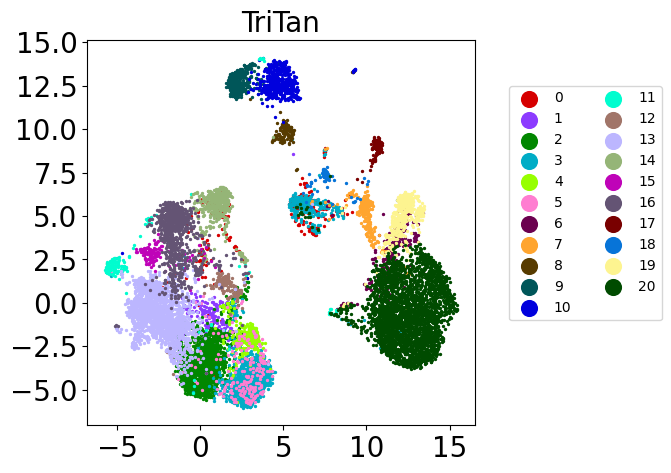

In [32]:
group1 = np.argmax(tritan.F.T, axis =0)
#group = np.argmax(F_new.T, axis =0)
cdict  = dict(zip(np.unique(group1), color_list))
fig, ax = plt.subplots()
for g in np.unique(group1):
    ix = np.where(group1 == g)[0]
    ax.scatter(sumap_embedding[:, 0][ix], sumap_embedding[:, 1][ix],c = cdict[g], label = g, s = 2)
ax.legend(bbox_to_anchor=(1, 0.4, 0.5, 0.5),ncol = 2,markerscale=8)
plt.title('TriTan', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("./PBMC-Multiome10k/TriTan.png", dpi=750, bbox_inches = 'tight')

In [31]:
adjusted_rand_score(celltype[['x']].values.T[0],group1)

0.7155657585214462

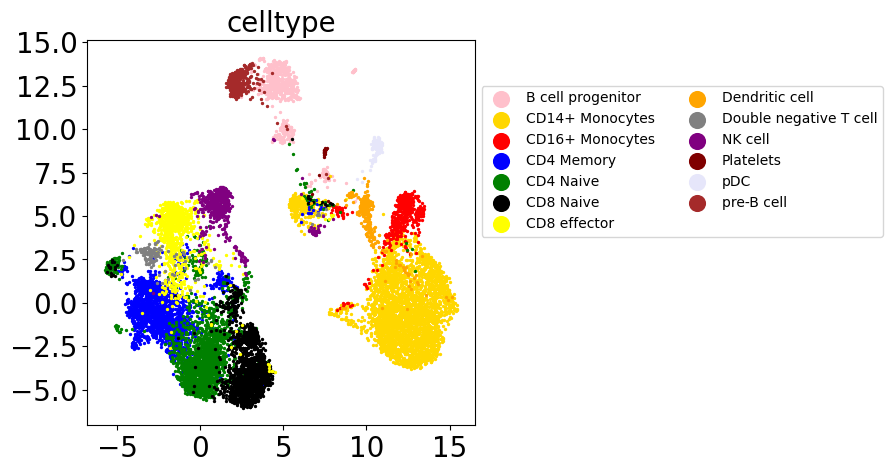

In [165]:
cdict = { 'B cell progenitor':"pink", 'CD14+ Monocytes':"gold",'CD16+ Monocytes':'red' ,'CD4 Memory':"blue",'CD4 Naive':'green'
         ,'CD8 Naive':'black','CD8 effector':'yellow','Dendritic cell':'orange', 'Double negative T cell':'gray', 'NK cell':'purple',
         'Platelets':'maroon',
       'pDC':'lavender', 'pre-B cell':'brown'}
group = celltype[['x']].values.T[0]
fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)[0]
    ax.scatter(sumap_embedding[:, 0][ix], sumap_embedding[:, 1][ix],c = cdict[g], label = g, s = 2)
ax.legend()
ax.legend(bbox_to_anchor=(1, 0.4, 0.5, 0.5),ncol = 2,markerscale=8)
plt.title('celltype', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("./PBMC-Multiome10k/celltype.png", dpi=750, bbox_inches = 'tight')